In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib
import theano
import theano.tensor as T
import pydot
from IPython.display import Image
from IPython.display import SVG
import timeit

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

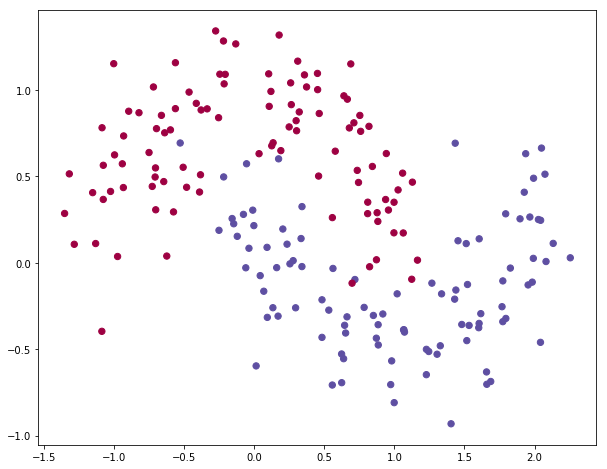

In [2]:
# Generate a dataset and plot it
np.random.seed(0)
train_X, train_y = sklearn.datasets.make_moons(200, noise=0.20)
train_X = train_X.astype(np.float32)
train_y = train_y.astype(np.int32)
plt.scatter(train_X[:,0], train_X[:,1], s=40, c=train_y, cmap=plt.cm.Spectral)

In [3]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = train_X[:, 0].min() - .5, train_X[:, 0].max() + .5
    y_min, y_max = train_X[:, 1].min() - .5, train_X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, cmap=plt.cm.Spectral)

In [29]:
# Size definitions
num_examples = len(train_X)
nn_input_dim = 2 # Input layer dimensionality
nn_output_dim = 2 # Ouput layer dimensionality
nn_hdim = 3 # Hidden layer dimensionality

# GD parameters
epsilon = 0.01 # Learning rate
reg_lambda = 0.01 # Regularization

In [30]:
# Data vectors
X = T.matrix('X') # Matrix of doubles
y = T.lvector('y') # Vector of int64

In [31]:
# Shared variables with initial values. We need to learn these
W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim), name='W1')
b1 = theano.shared(np.zeros(nn_hdim), name='b1')
W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim), name='W2')
b2 = theano.shared(np.zeros(nn_output_dim), name='b2')

In [32]:
# Forward propagation
# These are just defining the expressions, not evaluating them
z1 = X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2
y_hat = T.nnet.softmax(z2) # Output probabilities

# Regularization
loss_reg = 1./num_examples * reg_lambda/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2)))
# Loss function
loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg

# Class prediction
prediction = T.argmax(y_hat, axis=1)

In [33]:
# Theano functions
forward_prop = theano.function([X], y_hat)
calculate_loss = theano.function([X, y], loss)
predict = theano.function([X], prediction)

# Example
forward_prop([[1,2]])

array([[ 0.56040858,  0.43959142]])

The output file is available at img/nn-theano-forward_prop.png


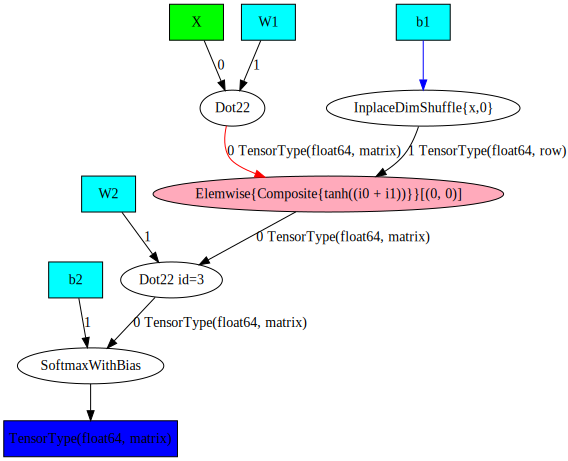

In [34]:
theano.printing.pydotprint(forward_prop, var_with_name_simple=True, compact=True, outfile='img/nn-theano-forward_prop.png', format='png')
SVG(theano.printing.pydotprint(forward_prop, var_with_name_simple=True, compact=True, return_image=True, format='svg'))

In [35]:
theano.printing.debugprint(forward_prop)

SoftmaxWithBias [id A] ''   4
 |Dot22 [id B] ''   3
 | |Elemwise{Composite{tanh((i0 + i1))}}[(0, 0)] [id C] ''   2
 | | |Dot22 [id D] ''   1
 | | | |X [id E]
 | | | |W1 [id F]
 | | |InplaceDimShuffle{x,0} [id G] ''   0
 | |   |b1 [id H]
 | |W2 [id I]
 |b2 [id J]


In [36]:
# Theano can calculate the derivatives
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)

# We could also define these manually
# in terms of Theano expressions
# y_onehot = T.eye(2)[y]
# delta3 = y_hat - y_onehot
# dW2 = (a1.T).dot(delta3) * (1. + reg_lambda)
# db2 = T.sum(delta3, axis=0)
# delta2 = delta3.dot(W2.T) * (1. - T.sqr(a1))
# dW1 = T.dot(X.T, delta2) * (1 + reg_lambda)
# db1 = T.sum(delta2, axis=0)

In [37]:
# This does a single gradient descent update
# Given X and y as inputs
gradient_step = theano.function(
 [X,y],
 updates=( (W2, W2 - epsilon*dW2),
           (W1, W1 - epsilon*dW1),
           (b2, b2 - epsilon*db2),
           (b1, b1 - epsilon*db1)))

# We don't need an explicit forward prop step, Theano handles that for us

In [38]:
# This function learns the paramters for the neural network and returns the model
# num_passes = Number of passes through the training data for gradient descent
# print_loss = If True, print the loss every 1000 iterations
def build_model(num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values
    # We need to learn these
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_dim, nn_hdim)/np.sqrt(nn_input_dim))
    b1.set_value(np.zeros((nn_hdim)))
    W2.set_value(np.random.randn(nn_hdim, nn_output_dim)/np.sqrt(nn_hdim))
    b2.set_value(np.zeros((nn_output_dim)))
    
    # Gradient descent. For each batch,
    for i in xrange(0, num_passes):
        # Parameter update
        gradient_step(train_X, train_y)
        
        if print_loss and i % 1000 == 0:
            print "Loss after iteration %i: %f" %(i, calculate_loss(train_X, train_y))

Loss after iteration 0: 0.582899
Loss after iteration 1000: 0.327102
Loss after iteration 2000: 0.306491
Loss after iteration 3000: 0.300981
Loss after iteration 4000: 0.295885
Loss after iteration 5000: 0.289264
Loss after iteration 6000: 0.280672
Loss after iteration 7000: 0.270248
Loss after iteration 8000: 0.258542
Loss after iteration 9000: 0.246241
Loss after iteration 10000: 0.233966
Loss after iteration 11000: 0.222174
Loss after iteration 12000: 0.211141
Loss after iteration 13000: 0.200995
Loss after iteration 14000: 0.191746
Loss after iteration 15000: 0.183330
Loss after iteration 16000: 0.175625
Loss after iteration 17000: 0.168472
Loss after iteration 18000: 0.161684
Loss after iteration 19000: 0.155086


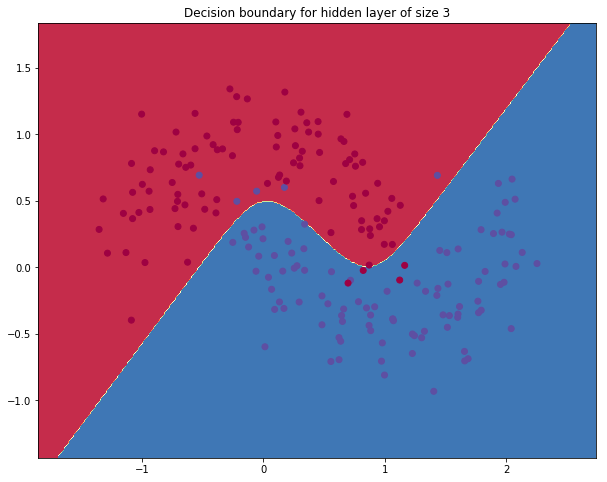

In [39]:
build_model(print_loss=True)

plot_decision_boundary(lambda x: predict(x))
plt.title("Decision boundary for hidden layer of size 3")